In [1]:
import numpy as np
import pandas as pd

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

sp5_components = pd.read_csv('sp5_components.csv')
etf_values = pd.read_csv('etf_values.csv', parse_dates=['Date'])
sp5_values = pd.read_csv('sp5_values.csv', parse_dates=['Date'])

# GET PRICE, RETURN, QUANTILE, AND RANK HISTORIES

In [2]:
def get_price_history(df):
    return df.pivot(index='Date', columns='Symbol', values='Adj Close')


def get_tail_days(df, days):
    return df.tail(days).dropna(axis=1, how='any')


def get_tail_date(df, date):
    return df.loc[df.index >= date].dropna(axis=1, how='any')


def get_return_history(df, days):
    return (df/df.shift(days) - 1).dropna(axis=0, how='all')*100


def get_quantile_history(df, window, quantile):
    return df.rolling(window).quantile(quantile).dropna(axis=0, how='all')


def get_rank_history(df):
    return df.rank(axis=1, method='first', ascending=False).astype('int64')


etf_price_history = get_price_history(etf_values)
sp5_price_history = get_price_history(sp5_values)

sp5_return_history = get_return_history(sp5_price_history, 63)

sp5_quantile_history = get_quantile_history(sp5_return_history, 252, 0.75)

sp5_rank_history = (sp5_quantile_history
    .pipe(get_tail_date, pd.Timestamp('2022-3-30'))
    .pipe(get_rank_history))

# display(etf_price_history)
# display(sp5_price_history)
# display(sp5_return_history)
# display(sp5_rank_history)

# GET TOP SYMBOLS

In [3]:
sp5_top_symbols = sp5_rank_history.iloc[-1].nsmallest(25).index.to_list()

sp5_top_components = (sp5_components
    .set_index('Symbol')
    .loc[sp5_top_symbols, ['Security', 'GICS Sub-Industry']]
    .reset_index())

display(sp5_top_components)

,Symbol,Security,GICS Sub-Industry
0,MRNA,Moderna,Biotechnology
1,DVN,Devon,Oil & Gas Exploration & Production
2,MRO,Marathon Oil,Oil & Gas Exploration & Production
3,APA,APA Corporation,Oil & Gas Exploration & Production
4,NVDA,Nvidia,Semiconductors
5,CF,CF Industries,Fertilizers & Agricultural Chemicals
6,AMD,AMD,Semiconductors
7,CTRA,Coterra,Oil & Gas Exploration & Production
8,NUE,Nucor,Steel
9,IT,Gartner,IT Consulting & Other Services


# PLOT TOP SYMBOLS

In [4]:
def set_cat_order(df, col, order):
    df[col] = df[col].astype('category').cat.reorder_categories(order)  
    return df


def get_tidy_history(df, symbol_order, tail_days, value_name):
    tidy = (df[symbol_order]
        .tail(tail_days)
        .melt(value_name=value_name, ignore_index=False)
        .reset_index()
        .pipe(set_cat_order, 'Symbol', symbol_order))
    return tidy

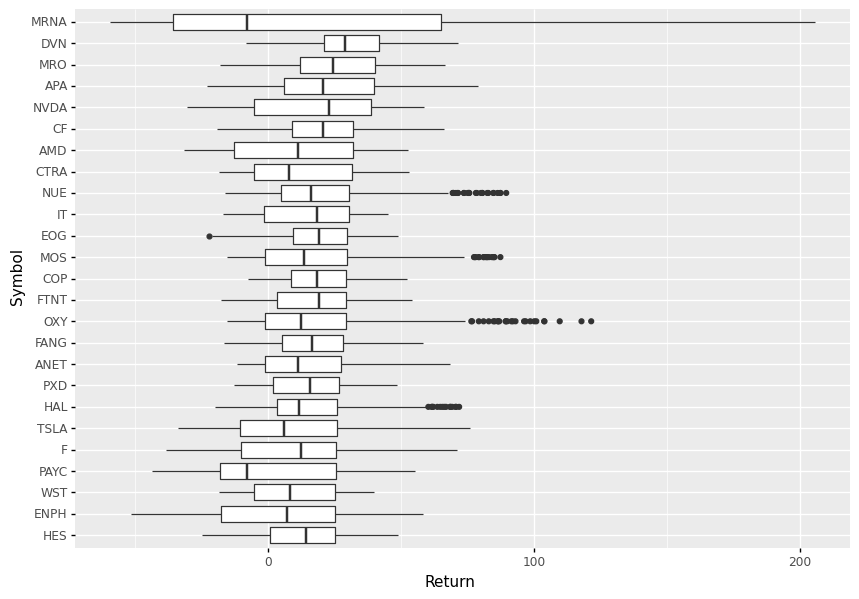

<ggplot: (8773292807190)>

In [5]:
data = get_tidy_history(sp5_return_history, sp5_top_symbols, 252, 'Return')

p =  p9.ggplot(data)
p += p9.theme(figure_size=(10, 7))
p += p9.geom_boxplot(mapping=p9.aes(x='Symbol', y='Return'))
p += p9.coord_flip()
p += p9.scale_x_discrete(limits=sp5_top_symbols[::-1])

display(p)

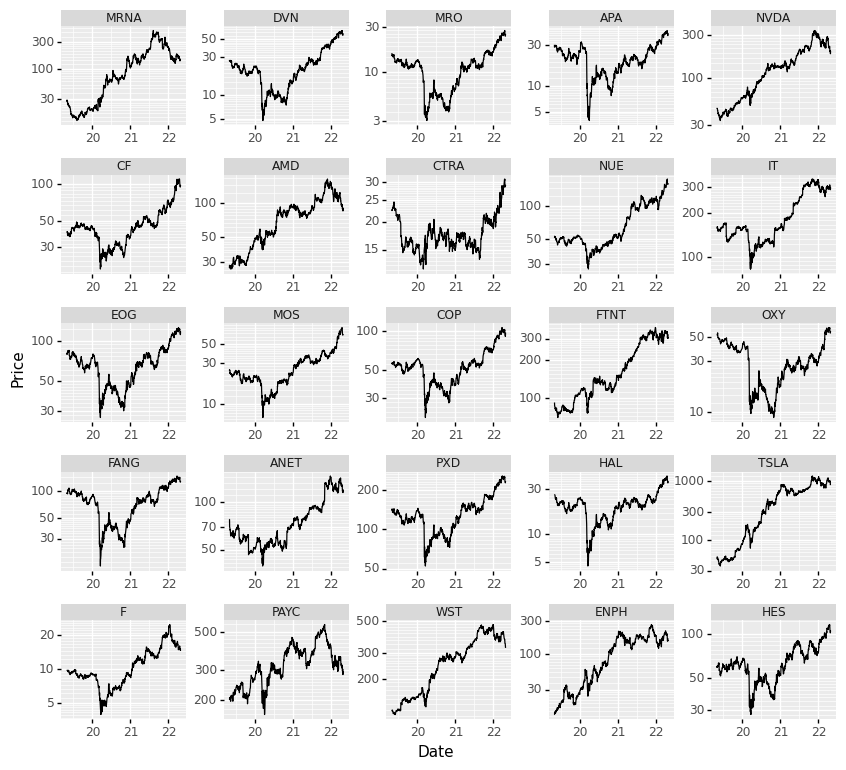

<ggplot: (8773259597659)>

In [6]:
data = get_tidy_history(sp5_price_history, sp5_top_symbols, 252*3, 'Price')

p  = p9.ggplot(data)
p += p9.theme(figure_size=(10, 9))
p += p9.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%y'))
p += p9.scale_y_log10()
p += p9.geom_line(mapping=p9.aes(x='Date', y='Price'))
p += p9.facet_wrap('Symbol', ncol=5, scales = 'free')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})

display(p)

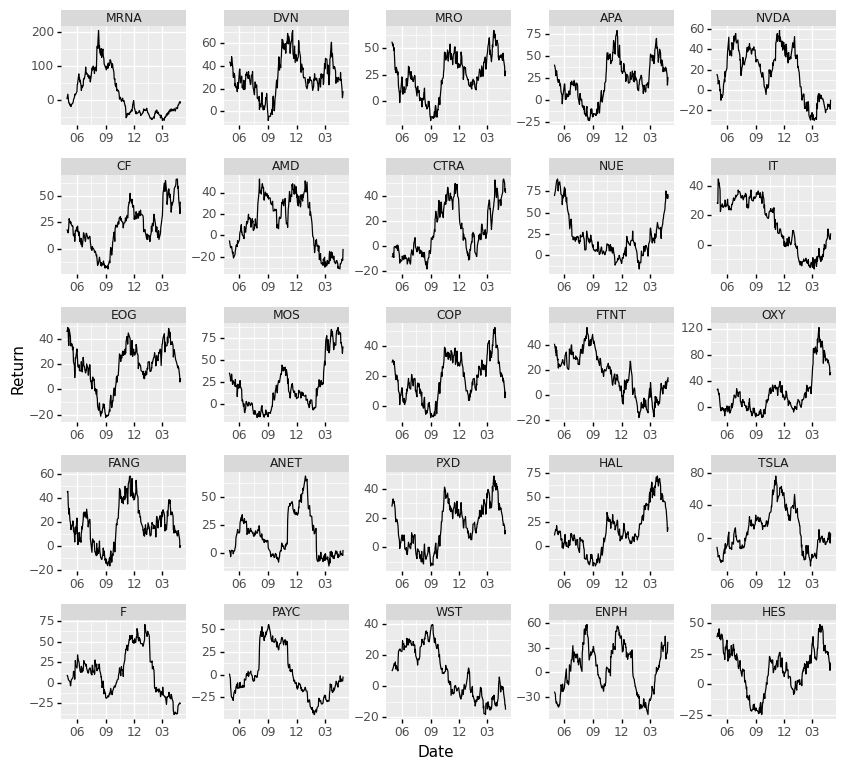

<ggplot: (8773293759299)>

In [7]:
data = get_tidy_history(sp5_return_history, sp5_top_symbols, 252*1, 'Return')

p  = p9.ggplot(data)
p += p9.theme(figure_size=(10, 9))
p += p9.scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%m'))
p += p9.geom_line(mapping=p9.aes(x='Date', y='Return'))
p += p9.facet_wrap('Symbol', ncol=5, scales = 'free')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})

display(p)

In [8]:
data = get_tidy_history(sp5_return_history, sp5_top_symbols, 252*1, 'Return')

p  = p9.ggplot(data)
p += p9.theme(figure_size=(10, 9))
p += p9.geom_histogram(mapping=p9.aes(x='Return'), binwidth=5)
p += p9.facet_wrap('Symbol', ncol=5, scales = 'free')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})

# display(p)

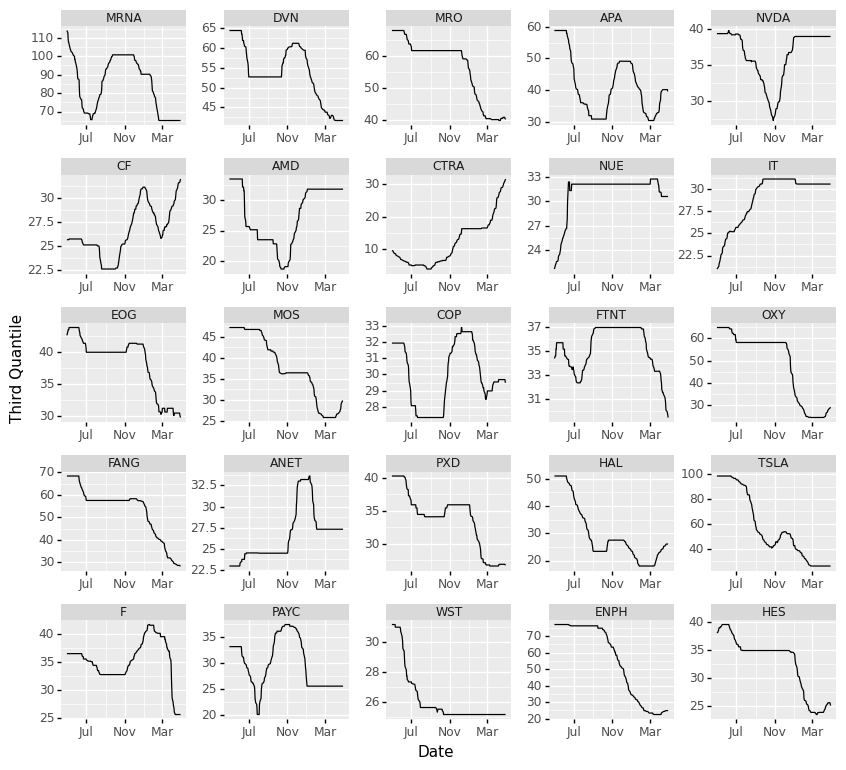

<ggplot: (8773315332672)>

In [9]:
data = get_tidy_history(sp5_quantile_history, sp5_top_symbols, 252*1, 'Third Quantile')

p  = p9.ggplot(data)
p += p9.theme(figure_size=(10, 9))
p += p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%b'))
p += p9.geom_line(mapping=p9.aes(x='Date', y='Third Quantile'))
p += p9.facet_wrap('Symbol', ncol=5, scales = 'free')
p += p9.theme(subplots_adjust={'hspace': 0.50, 'wspace': 0.30})

display(p)

# GET TRANSACTION HISTORY

In [10]:
def get_tran_history(name, data):
    df = pd.DataFrame(data, columns=['Date', 'Action', 'Qty', 'Symbol', 'Cost'])
    df = df.astype({'Date': 'datetime64[ns]'})
    df.name = name
    return df


exp_tran_history = get_tran_history('COCHRAN', [
    ['2022-3-30',  'buy',  4,  'AMD', 118.77  ],
    ['2022-3-30',  'buy', 12,  'APA',  41.0065],
    ['2022-3-30',  'buy',  8,  'DVN',  60.38  ],
    ['2022-3-30',  'buy',  4,  'EOG', 121.1263],
    ['2022-3-30',  'buy', 28,    'F',  17.275 ],
    ['2022-3-30',  'buy',  1, 'FTNT', 341.42  ],
    ['2022-3-30',  'buy',  2, 'MRNA', 174.63  ],
    ['2022-3-30',  'buy', 19,  'MRO',  25.38  ],
    ['2022-3-30',  'buy',  3,  'NUE', 149.23  ],
    ['2022-3-30',  'buy',  1, 'NVDA', 277.105 ],
    ['2022-3-31',  'buy',  3, 'FANG', 139.93  ],
    ['2022-4-21', 'sell', 28,    'F',  15.8703],
    ['2022-4-21',  'buy',  4,   'CF', 100.3   ]])

tec_tran_history = get_tran_history('AAPL MSFT' ,[
    ['2022-3-30', 'buy', 14, 'AAPL', 177.77   ],
    ['2022-3-31', 'buy',  8, 'MSFT', 313.86   ]])

ref_tran_history = get_tran_history('VOO', [
    ['2022-3-30', 'buy', 11,  'VOO', 421.65   ]])

# display(exp_tran_history.info())
# display(tec_tran_history.info())
# display(ref_tran_history.info())

# display(exp_tran_history)
# display(tec_tran_history)
# display(ref_tran_history)



exp_tran_history.merge(sp5_components[['Symbol', 'Security', 'GICS Sub-Industry']]).sort_values(['Date'])

,Date,Action,Qty,Symbol,Cost,Security,GICS Sub-Industry
0,2022-03-30,buy,4,AMD,118.7700,AMD,Semiconductors
1,2022-03-30,buy,12,APA,41.0065,APA Corporation,Oil & Gas Exploration & Production
2,2022-03-30,buy,8,DVN,60.3800,Devon,Oil & Gas Exploration & Production
3,2022-03-30,buy,4,EOG,121.1263,EOG Resources,Oil & Gas Exploration & Production
4,2022-03-30,buy,28,F,17.2750,Ford,Automobile Manufacturers
6,2022-03-30,buy,1,FTNT,341.4200,Fortinet,Systems Software
7,2022-03-30,buy,2,MRNA,174.6300,Moderna,Biotechnology
8,2022-03-30,buy,19,MRO,25.3800,Marathon Oil,Oil & Gas Exploration & Production
9,2022-03-30,buy,3,NUE,149.2300,Nucor,Steel
10,2022-03-30,buy,1,NVDA,277.1050,Nvidia,Semiconductors


# GET VALUE HISTORY, POSITIONS, AND CASH

In [11]:
def get_value_history(price_history, tran_history, start_cash):
    value_history = pd.Series(dtype='float64')
    positions = pd.Series(dtype='float64')
    cash = start_cash

    for date, prices in price_history.iterrows():
        logic = tran_history['Date'] == date
        trans = tran_history[logic]

        for i, row in trans.iterrows():
            _, action, qty, symbol, cost = row
            
            if action == 'buy':
                cash -= qty*cost
                positions[symbol] = qty
                
            if action == 'sell':
                cash += qty*cost
                positions = positions.drop(symbol)

        value = cash + (positions*prices).sum()
        value_history[date] = value
        
    value_history.name = tran_history.name
    value_history.index.name = 'Date'
    positions.name = tran_history.name
        
    return value_history, positions, cash

In [12]:
start_cash = 5_000
start_date = pd.Timestamp('2022-3-30')

exp_value_history, exp_positions, exp_cash = get_value_history(
    get_tail_date(sp5_price_history, start_date),
    exp_tran_history,
    start_cash)

tec_value_history, tec_positions, tec_cash = get_value_history(
    get_tail_date(sp5_price_history, start_date),
    tec_tran_history,
    start_cash)

ref_value_history, ref_positions, ref_cash = get_value_history(
    get_tail_date(etf_price_history, start_date),
    ref_tran_history,
    start_cash)

# exp_value_history.plot()
# ref_value_history.plot()
# tec_value_history.plot()

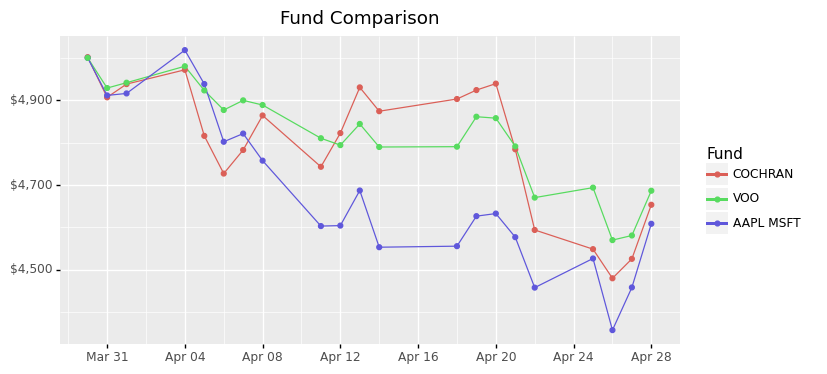

<ggplot: (8773314655028)>

In [13]:
data = (pd.DataFrame([exp_value_history, tec_value_history, ref_value_history]).T
    .melt(ignore_index=False, var_name='Fund', value_name='Value')
    .reset_index()
    .pipe(set_cat_order, 'Fund', ['COCHRAN', 'VOO', 'AAPL MSFT']))

p_funds = (p9.ggplot(data=data, mapping=p9.aes(x='Date', y='Value', color='Fund'))
    + p9.theme(figure_size=(8, 4))
    + p9.scale_x_datetime(breaks=date_breaks('4 days'), labels=date_format('%b %d'))
    + p9.geom_line()
    + p9.geom_point()
    + p9.labs(x=None, y=None)
    + p9.scale_y_continuous(labels=dollar_format(prefix='$', digits=0, big_mark=','))
    + p9.ggtitle('Fund Comparison'))

display(p_funds)

In [14]:
exp = set(exp_positions.index)
sp5 = set(sp5_rank_history.columns)
non = sp5 - exp

display(sp5_rank_history[sp5_rank_history[exp]
    .iloc[-1].sort_values().index])

display(sp5_rank_history[sp5_rank_history[non]
    .iloc[-1].sort_values().index].iloc[:, :5])

Symbol,MRNA,DVN,MRO,APA,NVDA,CF,AMD,NUE,EOG,FTNT,FANG
Date,,,,,,,,,,,
2022-03-30,1,2,3,5,4,14,8,9,10,6,11
2022-03-31,1,2,3,5,4,14,7,9,8,6,10
2022-04-01,1,2,3,5,4,13,7,9,8,6,10
2022-04-04,1,2,3,5,4,13,7,9,8,6,11
2022-04-05,1,2,3,5,4,13,7,8,10,6,11
2022-04-06,1,2,3,4,5,13,7,8,10,6,11
2022-04-07,1,2,3,4,5,13,7,8,10,6,12
2022-04-08,1,2,3,4,5,12,6,8,10,7,13
2022-04-11,1,2,4,3,5,11,6,8,10,7,13


Symbol,CTRA,IT,MOS,COP,OXY
Date,,,,,
2022-03-30,26,12,21,13,25
2022-03-31,22,11,21,13,26
2022-04-01,21,11,22,12,26
2022-04-04,21,10,22,12,25
2022-04-05,19,9,20,12,25
2022-04-06,19,9,20,12,25
2022-04-07,16,9,20,11,25
2022-04-08,14,9,18,11,25
2022-04-11,14,9,17,12,25


In [ ]:
# num_hold = 10
# start_cash = 5_000
# cash_per 

# get_ranks

# sell_high

# buy_low